## Прогнозирование температуры звезды

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

Закон смещения Вина.

Закон Стефана-Больцмана.

Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики

Относительная светимость L/Lo — светимость звезды относительно Солнца.

Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.

Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

Тип звезды.


Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

**ОГЛАВЛЕНИЕ**

<a href='#1'>Загрузка данных</a>

<a href='#2'>Предобработка и анализ данных</a>

<a href='#3'>Корреляционный анализ</a>

<a href='#4'>Построение базовой нейронной сети</a>

<a href='#5'>Улучшение нейронной сети</a>

<a href='#6'>Выводы</a>

In [1]:
!pip install phik -q

!pip install scikit-learn==1.1.3 -q

In [2]:
import torch
import torch.nn as nn
#import torchvision
#import torchvision.transforms as transforms
import random

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

from phik.report import correlation_report, plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    f1_score
)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

RANDOM_STATE = 42
TEST_SIZE = 0.25

<a id='1'></a>
## Загрузка данных

In [3]:
try:
    stars = pd.read_csv('/datasets/6_class.csv', sep=',', index_col=0)
    
except:
    stars = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv', sep=',', index_col=0)

In [4]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [5]:
data_info(stars)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
count,240.000000,240.000000,240.000000,240.000000,240.000000,240
unique,NaN,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,NaN,Red
freq,NaN,NaN,NaN,NaN,NaN,112
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,NaN
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,NaN
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,NaN
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,NaN
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,NaN
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


Выведем долю пропущенных значений для каждого столбца датафреймов.

In [6]:
pd.DataFrame(stars.isna().mean()*100)

,0
Temperature (K),0.0
Luminosity(L/Lo),0.0
Radius(R/Ro),0.0
Absolute magnitude(Mv),0.0
Star type,0.0
Star color,0.0


Для анализа предоставлен датафрейм из 240 строк с различными характеристиками звезд, на основании которых требуется предсказать температуру звезды, которая является целевым признаком в данной задаче.

Пропусков в данных не обнаружено.

<a id='2'></a>
## Предобработка и анализ данных

Посмотрим, есть ли строки дубликаты в представленных данных.

In [7]:
stars.duplicated().sum()

0

Дубликатов в данных не обнаружено.

Переименуем толбцы однотипным образом.

In [8]:
stars = stars.rename(columns={'Temperature (K)': 'Temperature_K', 'Luminosity(L/Lo)': 'Luminosity_L/Lo',
                             'Radius(R/Ro)': 'Radius_R/Ro', 'Absolute magnitude(Mv)': 'Absolute_magnitude_Mv',
                             'Star type': 'Star_type', 'Star color': 'Star_color'})

In [9]:
stars.head(5)

,Temperature_K,Luminosity_L/Lo,Radius_R/Ro,Absolute_magnitude_Mv,Star_type,Star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Посмотрим на уникальные значения категориальных признаков.

In [10]:
stars['Star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [11]:
stars['Star_color'].nunique()

19

In [12]:
stars['Star_color'] = stars['Star_color'].str.lower()

In [13]:
stars['Star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'blue ', 'yellowish',
       'orange-red', 'blue white '], dtype=object)

In [14]:
stars['Star_color'].nunique()

15

Видно, что в наименованиях цвета звезд присутствует некоторая путаница.

В интернете можно найти следующие данные по классификации цвета звезд:

The standard classes are (temperatures are in Kelvin):

O – Blue Stars: > 30,000 K

B – Blue-White Stars: 10,000 – 30,000 K

A – White Stars: 7,500 – 10,000 K

F – Yellow-White Stars: 6,000 – 7,500 K

G – Yellow Stars: 5,200-6,000 K

K – Orange Stars: 3,700 – 5,200 K

M – Red Stars: 2,400 – 3,700 K


Приведем все названия к данным семи типам цветов звезд.

In [15]:
stars['Star_color'] = np.where(stars['Star_color'] == 'blue white', 'blue-white', stars['Star_color'])
stars['Star_color'] = np.where(stars['Star_color'] == 'blue white ', 'blue-white', stars['Star_color'])
stars['Star_color'] = np.where(stars['Star_color'] == 'whitish', 'white', stars['Star_color'])

In [16]:
stars['Star_color'] = np.where(stars['Star_color'] == 'blue ', 'blue', stars['Star_color'])

In [17]:
stars['Star_color'] = np.where(stars['Star_color'] == 'yellowish white', 'yellow-white', stars['Star_color'])
stars['Star_color'] = np.where(stars['Star_color'] == 'white-yellow', 'yellow-white', stars['Star_color'])
stars['Star_color'] = np.where(stars['Star_color'] == 'yellowish', 'yellow', stars['Star_color'])

In [18]:
stars['Star_color'].unique()

array(['red', 'blue-white', 'white', 'yellow-white', 'pale yellow orange',
       'blue', 'orange', 'yellow', 'orange-red'], dtype=object)

Заменим два типа звезд pale yellow orange и orange-red на типы звезд из таблицы выше, соответствующие их температуре.

In [19]:
stars.query('Star_color == "pale yellow orange"')

,Temperature_K,Luminosity_L/Lo,Radius_R/Ro,Absolute_magnitude_Mv,Star_type,Star_color
29,7230,0.00008,0.013,14.08,2,pale yellow orange


In [20]:
stars['Star_color'] = np.where(stars['Star_color'] == 'pale yellow orange', 'yellow-white', stars['Star_color'])

In [21]:
stars.query('Star_color == "orange-red"')

,Temperature_K,Luminosity_L/Lo,Radius_R/Ro,Absolute_magnitude_Mv,Star_type,Star_color
96,5112,0.63,0.876,4.68,3,orange-red


In [22]:
stars['Star_color'] = np.where(stars['Star_color'] == 'orange-red', 'orange', stars['Star_color'])

In [23]:
stars['Star_color'].unique()

array(['red', 'blue-white', 'white', 'yellow-white', 'blue', 'orange',
       'yellow'], dtype=object)

In [24]:
stars['Star_color'].nunique()

7

В итоге осталось семь цветов звезд, как в таблице.

Посмотрим на распределение четырех числовых и двух категориальных признаков. 

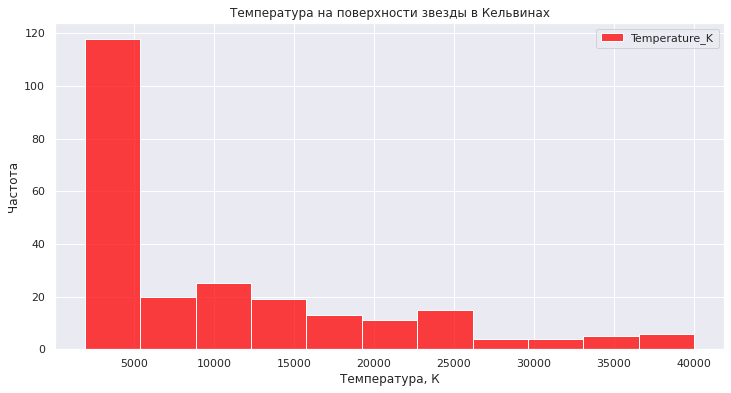

In [25]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=stars, x="Temperature_K", color="red", label="Temperature_K")

plt.ylabel('Частота')
plt.xlabel('Температура, К')
plt.title('Температура на поверхности звезды в Кельвинах')
plt.legend() 
plt.show()

В данных премущественно представлены сведения о не самых горячих звездах с температрами ниже 5000 К.

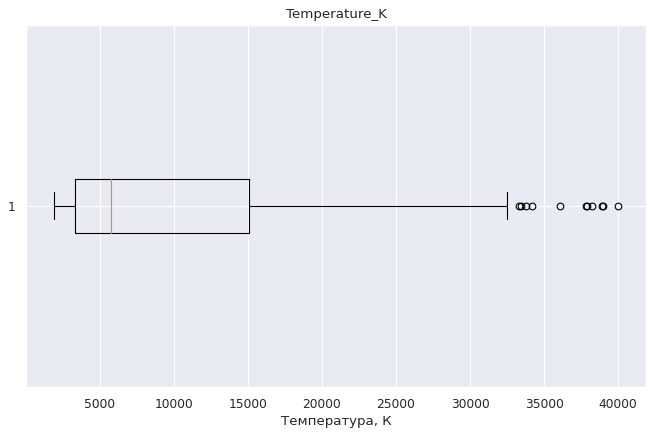

In [26]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(stars['Temperature_K'], vert=False)
plt.title('Temperature_K')
plt.xlabel('Температура, К')
plt.show()

Видно, что основная часть звезд имеют температуру в диапазоне от 3300 до 15000 К. Распределение температуры сильно сдвинуто влево. Среднее значение температуры - 10500 К, медианное - 5800 К. Наблюдаются выбросы - значения выше 33000 К. Поскольку в действительности такие температуры звезд имеют место, то ничего из данных не выбрасываем.

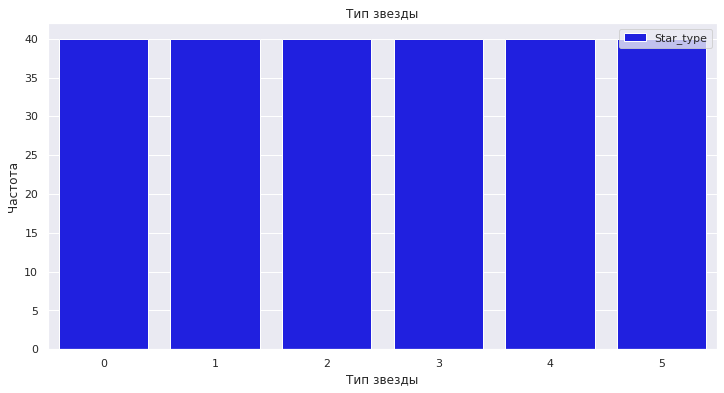

In [27]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=stars, x="Star_type", color="blue", label="Star_type")

plt.ylabel('Частота')
plt.xlabel('Тип звезды')
plt.title('Тип звезды')
plt.legend() 
plt.show()

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

Распределение звезд по типам - равномерное.

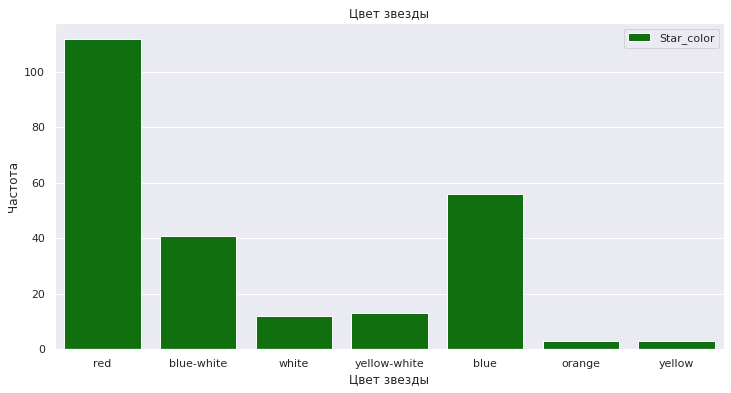

In [28]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=stars, x="Star_color", color="green", label="Star_color")

plt.ylabel('Частота')
plt.xlabel('Цвет звезды')
plt.title('Цвет звезды')
plt.legend() 
plt.show()

Из графика видно, что больше всего красных (не очень горячих) звезд, что соответствует распределению звезд по температуре.

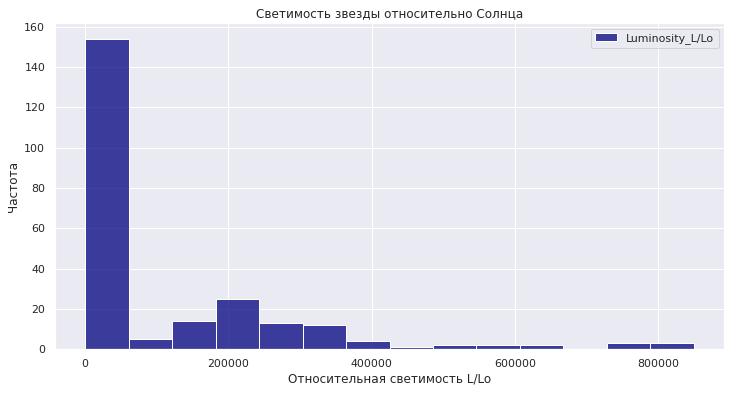

In [29]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=stars, x="Luminosity_L/Lo", color="navy", label="Luminosity_L/Lo")

plt.ylabel('Частота')
plt.xlabel('Относительная светимость L/Lo')
plt.title('Светимость звезды относительно Солнца')
plt.legend() 
plt.show()

Распределение относительной светимости несимметричное, сдвинуто влево. Присутствует большое число звезд с низкой светимостью.

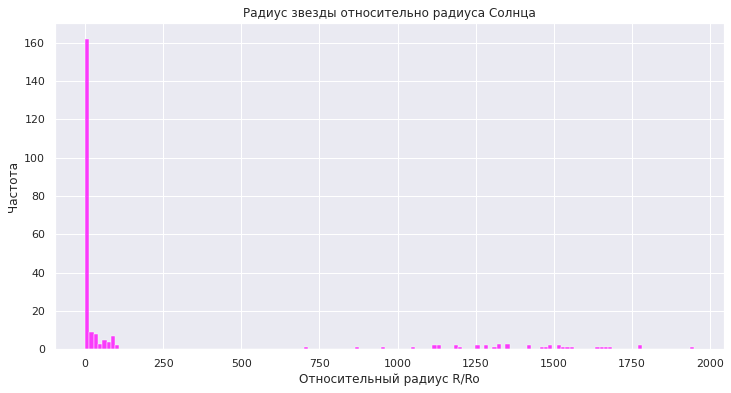

In [30]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=stars, x="Radius_R/Ro", color="magenta", label="Radius_R/Ro")

plt.ylabel('Частота')
plt.xlabel('Относительный радиус R/Ro')
plt.title('Радиус звезды относительно радиуса Солнца')
plt.show()

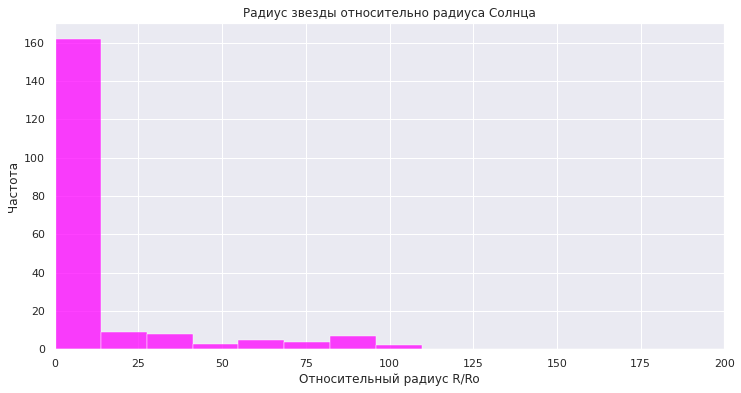

In [31]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=stars, x="Radius_R/Ro", color="magenta", label="Radius_R/Ro")
plt.xlim(0, 200)
plt.ylabel('Частота')
plt.xlabel('Относительный радиус R/Ro')
plt.title('Радиус звезды относительно радиуса Солнца')
plt.show()

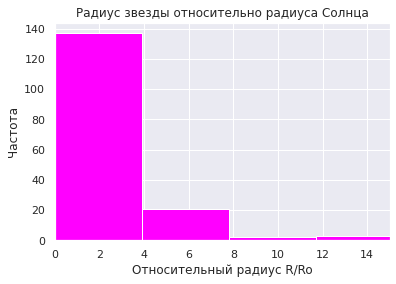

In [32]:
stars['Radius_R/Ro'].plot(
kind='hist',
bins=500,
color='magenta'
)
plt.xlim(0, 15)
plt.ylabel('Частота')
plt.xlabel('Относительный радиус R/Ro')
plt.title('Радиус звезды относительно радиуса Солнца')
plt.show()

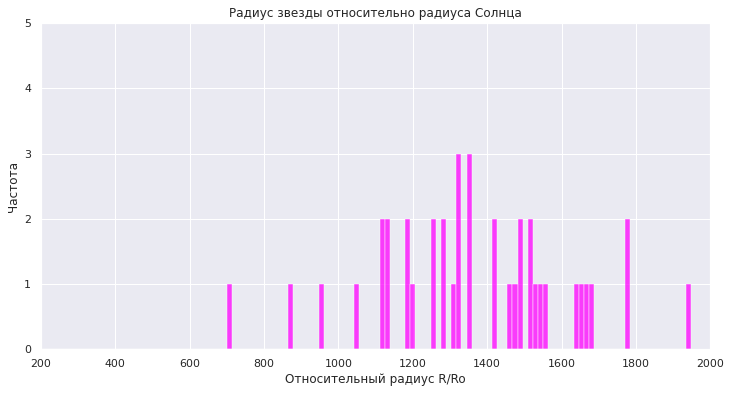

In [33]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=stars, x="Radius_R/Ro", color="magenta", label="Radius_R/Ro")
plt.ylim(0, 5)
plt.xlim(200, 2000)
plt.ylabel('Частота')
plt.xlabel('Относительный радиус R/Ro')
plt.title('Радиус звезды относительно радиуса Солнца')
plt.show()

В основном в данных присутствуют звезды, близкие по радиусу к Солнцу, однако есть и звезды - гиганты.

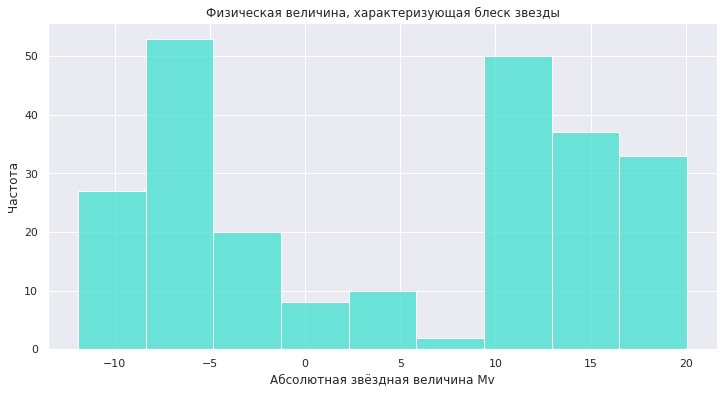

In [34]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=stars, x="Absolute_magnitude_Mv", color="turquoise", label="Absolute_magnitude_Mv")

plt.ylabel('Частота')
plt.xlabel('Абсолютная звёздная величина Mv')
plt.title('Физическая величина, характеризующая блеск звезды')
plt.show()

Распределение звезд по абсолютной звездной величине - бимодальное. В основном присутствуют либо очень яркие, либо тусклые звезды.

Посмотрим на взаимосвязь целевого признака - температуры звезды с остальными параметрами.

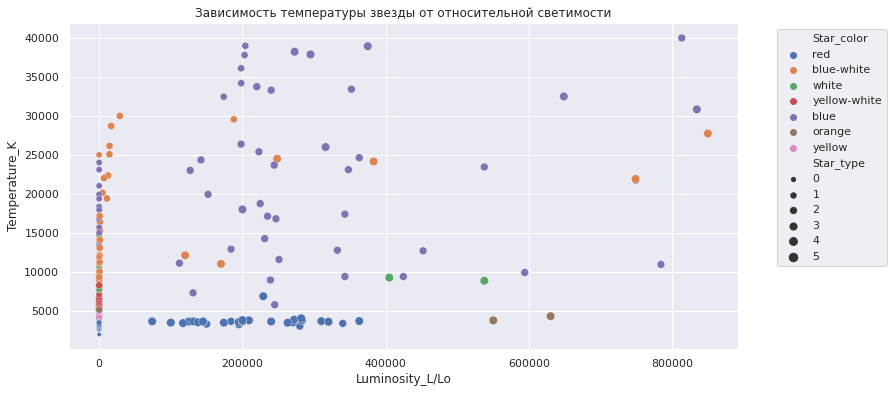

In [35]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=stars, 
    x="Luminosity_L/Lo", 
    y="Temperature_K", 
    hue="Star_color", 
    size="Star_type"
)
plt.title('Зависимость температуры звезды от относительной светимости')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left');

В целом, зависимости между относительной светимостью и температурой не видно, видно только, что у всех красных звезд примерно одинаковая температура, которая не зависит от относительной светимости. 

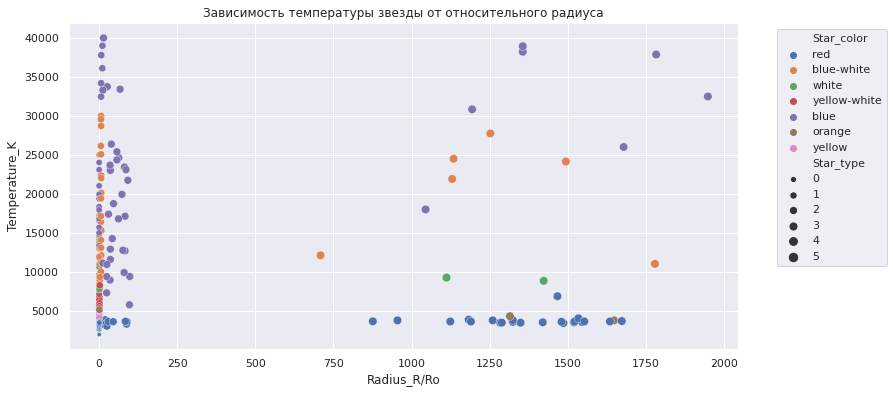

In [36]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=stars, 
    x="Radius_R/Ro", 
    y="Temperature_K", 
    hue="Star_color", 
    size="Star_type"
)
plt.title('Зависимость температуры звезды от относительного радиуса')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left');

Такая же картина для относительного радиуса. Для красных звезд температура просто определяется цветом звезды, то есть спектром. Общей зависимости нет.

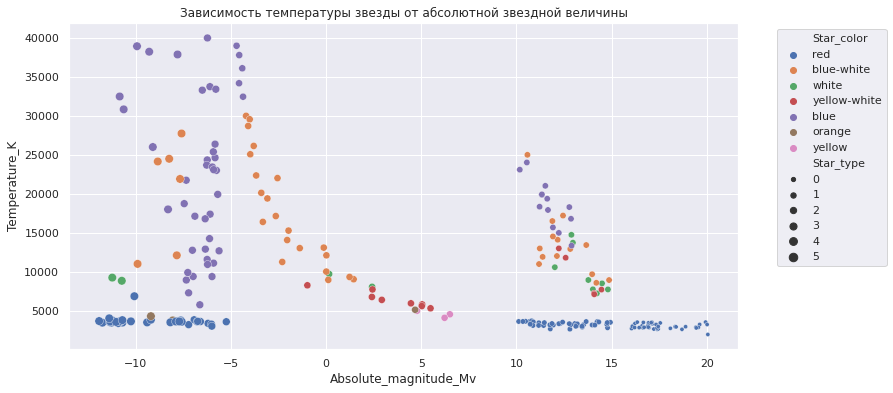

In [37]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=stars, 
    x="Absolute_magnitude_Mv", 
    y="Temperature_K", 
    hue="Star_color", 
    size="Star_type"
)
plt.title('Зависимость температуры звезды от абсолютной звездной величины')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left');

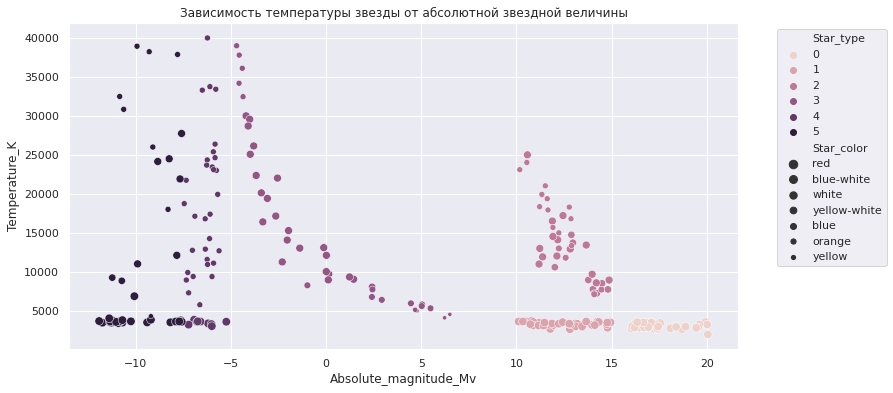

In [38]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=stars, 
    x="Absolute_magnitude_Mv", 
    y="Temperature_K", 
    hue="Star_type", 
    size="Star_color"
)
plt.title('Зависимость температуры звезды от абсолютной звездной величины')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left');

Зависимость температуры от абсолютной звездной величины можно было бы определить для разных типов звезд. 3 тип звезд (звезды главной последовательности) хорошо ложатся на кривую типа exp(-x). На ее продолжение также хорошо попадают звезды 0 и 1 типа (коричневые и красные карлики). Зависимость для 2 типа звезд (белые карлики) можно было бы приблизительно считать линейной. То есть тут можно было бы обучать данные раздельно.
Из этого графика, как и из других, видно, что самые большие проблемы будут с предсказаниями звезд гигантов.

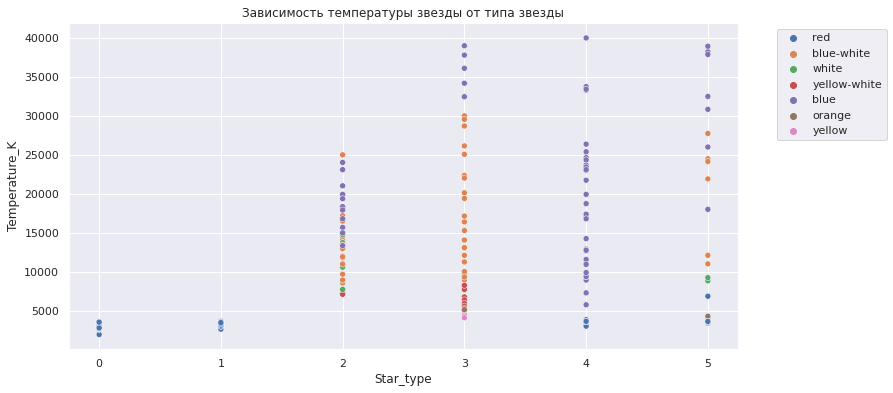

In [39]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=stars, 
    x="Star_type", 
    y="Temperature_K", 
    hue="Star_color" 
)
plt.title('Зависимость температуры звезды от типа звезды')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left');

Из графика видно, что для звезд 0 и 1 типа практически однозначно определяется температура. Они же преимущественно являются красными.

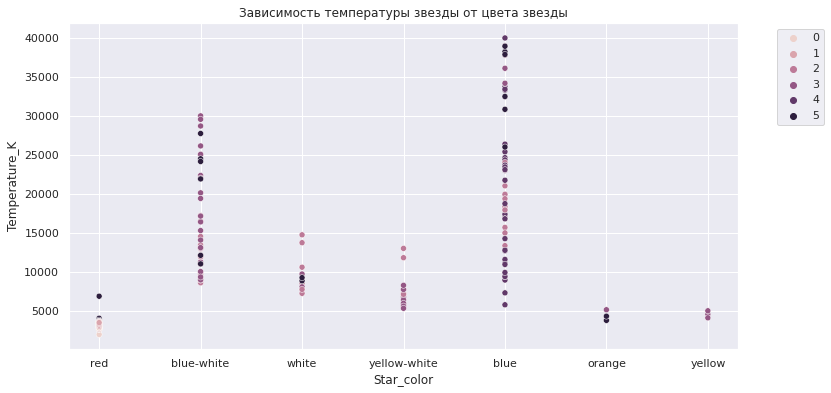

In [40]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=stars, 
    x="Star_color", 
    y="Temperature_K", 
    hue="Star_type" 
)
plt.title('Зависимость температуры звезды от цвета звезды')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left');

Из этого графика видно, что такие цвета звезды как красный, оранжевый и желтый практически однозначно определят температуру звезды.

<a id='3'></a>
## Корреляционный анализ

Построим матрицу корреляций Phi_K.

In [41]:
num_col = ['Temperature_K', 'Luminosity_L/Lo', 'Radius_R/Ro', 'Absolute_magnitude_Mv']

In [42]:
data_phik = stars.phik_matrix(interval_cols = num_col)
display(data_phik)

,Temperature_K,Luminosity_L/Lo,Radius_R/Ro,Absolute_magnitude_Mv,Star_type,Star_color
Temperature_K,1.000000,0.562667,0.236637,0.710472,0.603924,0.718073
Luminosity_L/Lo,0.562667,1.000000,0.574964,0.709456,0.654026,0.464402
Radius_R/Ro,0.236637,0.574964,1.000000,0.512414,0.635115,0.158821
Absolute_magnitude_Mv,0.710472,0.709456,0.512414,1.000000,0.915921,0.695811
Star_type,0.603924,0.654026,0.635115,0.915921,1.000000,0.667545
Star_color,0.718073,0.464402,0.158821,0.695811,0.667545,1.000000


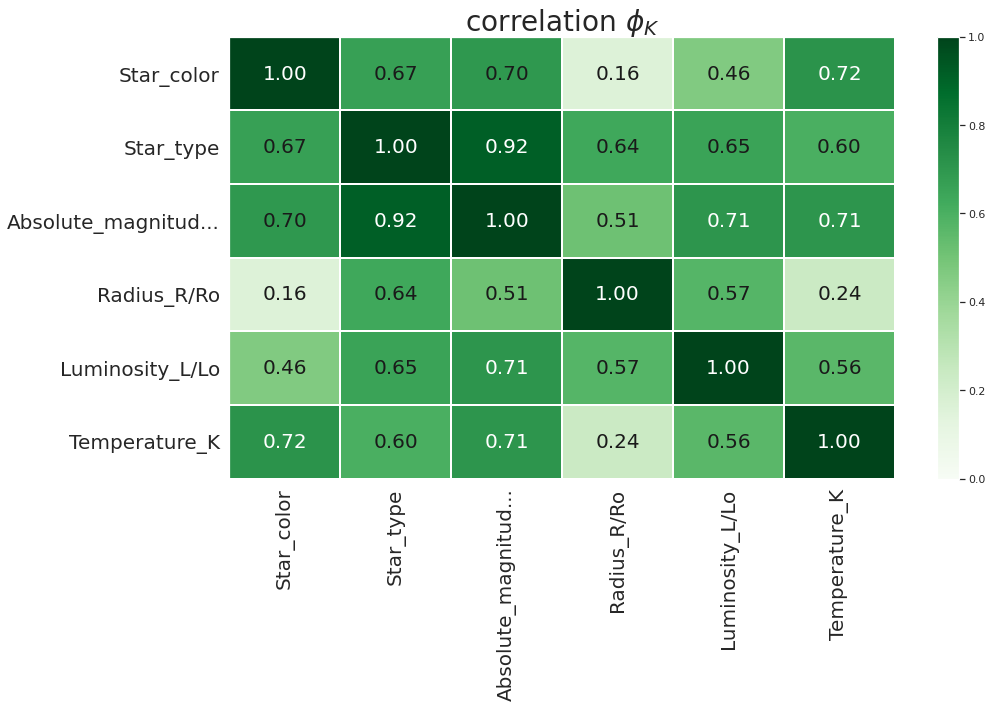

In [43]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=2, 
                        figsize=(15, 10))

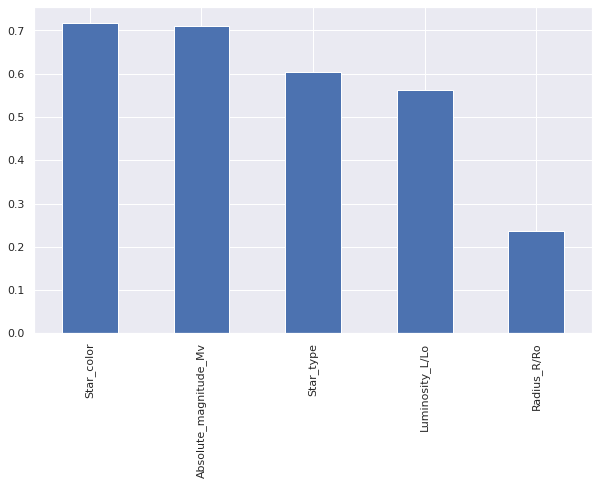

In [44]:
plt.figure(figsize=(10, 6))
_ = data_phik['Temperature_K'].sort_values(ascending=False)[1:].plot(kind='bar')

Построение корреляционной матрицы подтверждает выводы, сделанные выше на основании графиков зависимости температуры от различных параметров звезды.

Самая высокая степень корреляции наблюдается между целевым признаком и цветом звезды, а также абсолютной звездной величиной (0.7). Вместе с этим наблюдается очень высокая корреляция между двумя этими признаками - 0.92. При построении линейной модели, наверное, следовало бы оставить только один из этих признаков.

<a id='4'></a>
## Построение базовой нейронной сети

In [45]:
num_col = ['Luminosity_L/Lo', 'Radius_R/Ro', 'Absolute_magnitude_Mv']
cat_col = ['Star_type', 'Star_color']

Сделаем масштабирование числовых и кодирование категориальных признаков. Прочитала, что что нейросеть лучше предсказывает, когда нет параметра drop='first' для кодировщика OHE, поэтому убрала эту строчку.

In [46]:
preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), num_col),
                ("category", OneHotEncoder(handle_unknown='ignore', sparse=False), cat_col)
            ]
        )

Раделим данные на обучающие и целевые.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    stars.drop(columns=['Temperature_K']), 
    stars.Temperature_K, 
    test_size=TEST_SIZE, 
    random_state = RANDOM_STATE)

In [48]:
preprocessor.fit(X_train)

X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

Преобразуем данные в тензорный вид.

In [49]:
X_train = torch.FloatTensor(X_train_p)
X_test = torch.FloatTensor(X_test_p)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Посчитаем, сколько признаков получилось после преобразований.

In [50]:
X_train.shape[1]

16

In [51]:
# Исходные данные для случайных значений модели
torch.manual_seed(1974)
torch.use_deterministic_algorithms(True)

Задаем архитектуру нейронной сети и переопределяем метод forward. Он принимает на вход тензор и возвращает его на выходе, после прохождения через нейронную сеть.

Задаем сеть с тремя скрытыми слоями. В качестве функции активации используем ReLU, так как она лучше работает с моделями регрессии.

In [52]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        return x

In [53]:
net = Net(16, 11, 7, 5, 1)

In [54]:
num_epochs = 2000

Используем оптимизатор Adam. Перед каждым шагом обнуляем накопленный градиент методом zero_grad(). Затем вычисляем текущие предсказания модели и подсчитываем значение функции потерь. После этого с помощью метода backward() вычисляем значение градиента функции потерь и выполняем шаг работы оптимизатора (обновление весов в сети).

В качестве метрики будем использовать RMSE, в качестве функции потерь, соответственно - MSE.

Задаем число эпох 2000. Перед вычислением метрики качества переводим модель в режим предсказания — вызываем метод eval(). В этом режиме не будут вычисляться и накапливаться градиенты. 

In [55]:
def learn(net, num_epochs):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
    loss = nn.MSELoss()
    results = np.array([])
    results_test = np.array([])
    for epoch in range(num_epochs):
        optimizer.zero_grad()
          
        preds = net.forward(X_train).flatten()
        
        loss_value = loss(preds, y_train)
        
        loss_value.backward()
        
        optimizer.step()
        
        if epoch % 10 == 0:
            net.eval()
            test_preds = net.forward(X_test)
        
            #print(torch.sqrt(loss_value))
            res = mean_squared_error(y_train, net.forward(X_train).detach().numpy(), squared=False)
            res_test = mean_squared_error(y_test, test_preds.detach().numpy(), squared=False)
            results = np.append(results, res)
            results_test = np.append(results_test, res_test)
    return test_preds, res, res_test, results, results_test

In [56]:
test_preds, rmse, rmse_test, results, results_test = learn(net, num_epochs)

In [57]:
print('RMSE на тестовой выборке:', rmse_test)

RMSE на тестовой выборке: 4951.3657


In [58]:
print('RMSE на обучающей выборке:', rmse)

RMSE на обучающей выборке: 3713.2393


В итоге значение метрики RMSE на обучающей выборке получилось равным 3700, что меньше требуемой в задаче 4500.

Выведем тензор с предсказаниями и определим количество предсказанных температур (60).

In [59]:
print(test_preds.data.flatten())

tensor([14788.3037,  3120.7722,  3194.5720, 16234.7998, 22245.1309,  4583.5063,
        22328.4707, 14241.0918,  2934.2151, 14719.9707,  3170.2190, 20959.5312,
         3459.0012, 16566.7637,  3419.2585, 17138.9727,  3191.7136,  3229.8210,
        17552.6797,  2967.6531,  3127.3330,  3329.4451, 33259.1719, 35176.9375,
        30797.6035, 16261.2939,  3514.1814, 18158.9004,  9896.5146, 20164.9238,
         3107.9934, 16225.5850, 11985.9678,  2967.6531,  3364.4128,  2967.6531,
         3341.0344,  3867.5332,  3496.0815,  3443.2793, 21906.1035,  4043.5422,
        17541.5195,  3081.0156, 20772.1602,  2967.6531, 24222.6230,  5616.4175,
         3452.9146,  2986.8589, 19589.8750,  2967.6531, 21715.9414,  3166.6682,
        18645.8516, 18772.1973,  3831.4836, 11358.4443,  3041.8457,  3235.3235])


In [60]:
print(len(test_preds))

60


Сравним значения, предсказанные моделью на тестовой выборке с действительными значениями.

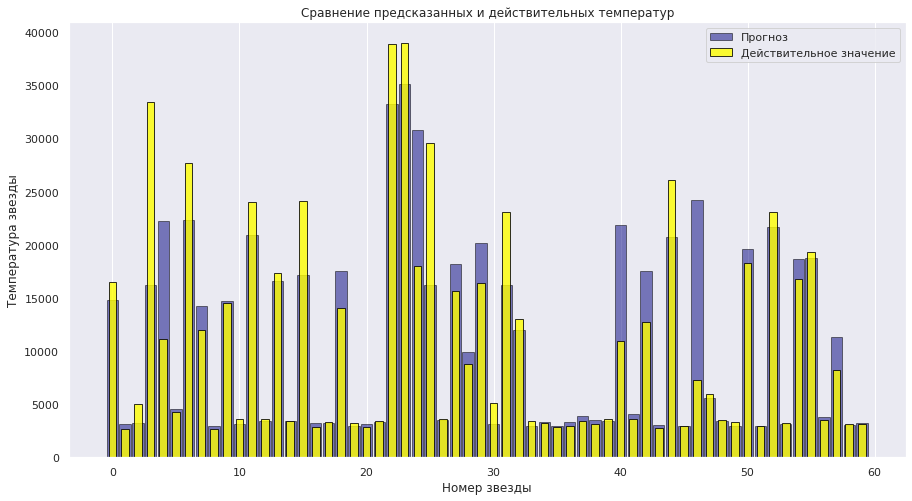

In [61]:
x = np.arange(60)
plt.figure(figsize = (15,8))
plt.bar(x, test_preds.data.flatten()[:60], width = 0.9, color = 'navy', edgecolor = 'black', label='Прогноз', alpha=0.5)
plt.bar(x, y_test[:60], width = 0.6, color = 'yellow', edgecolor = 'black', alpha=0.8, label='Действительное значение')
plt.title('Сравнение предсказанных и действительных температур')
plt.ylabel('Температура звезды')
plt.xlabel('Номер звезды')
plt.legend()
plt.grid(axis='y')
plt.show()

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
ОК, исследована "базовая" модель, есть график "план-факт". </div>

In [62]:
print(y_test.detach().numpy())

[16500.  2637.  4980. 33421. 11096.  4287. 27739. 12010.  2700. 14520.
  3600. 24020.  3610. 17383.  3399. 24145.  2889.  3340. 14060.  3225.
  2861.  3441. 38940. 39000. 18000. 29560.  3600. 15680.  8829. 16390.
  5112. 23095. 12990.  3419.  3192.  2871.  2994.  3450.  3158.  3614.
 10930.  3615. 12749.  2799. 26140.  2945.  7282.  5936.  3541.  3341.
 18340.  2968. 23092.  3212. 16787. 19360.  3553.  8250.  3150.  3091.]


Из сравнения видно, что лучше всего модель предсказывает температуры меньше 5000 К, то есть температуры красных звезд. Это неудивительно, так как именно для этих звезд цвет звезды практически однозначно определяет температуру.

Посмотрим повнимательнее на звезды, для которых модель дала самые большие расхождения с реальными данными. Номера этих звезд на графике: 3, 4, 24, 24, 40 и 46. Определим их индексы в исходном датафрейме и выведем таблицу с характеристиками этих звезд.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    stars.drop(columns=['Temperature_K']), 
    stars.Temperature_K, 
    test_size=TEST_SIZE, 
    random_state = RANDOM_STATE)

In [64]:
test = pd.DataFrame(columns=['star_number', 'Temperature_K'])

In [65]:
test['Temperature_K'] = y_test

In [66]:
test['star_number'] = y_test.index

In [67]:
test = test.reset_index(drop = 'True')

In [68]:
bad = test.query('index == 3 or index == 4 or index == 24 or index == 25 or index == 40 or index == 46')

In [69]:
list = bad['star_number']

In [70]:
list

3     109
4     104
24    176
25    150
40    227
46    165
Name: star_number, dtype: int64

In [71]:
stars.query('index in @list')

,Temperature_K,Luminosity_L/Lo,Radius_R/Ro,Absolute_magnitude_Mv,Star_type,Star_color
104,11096,112000.0,12.00,-5.910,4,blue
109,33421,352000.0,67.00,-5.790,4,blue
150,29560,188000.0,6.02,-4.010,3,blue-white
165,7282,131000.0,24.00,-7.220,4,blue
176,18000,200000.0,1045.00,-8.300,5,blue
227,10930,783930.0,25.00,-6.224,4,blue


Из таблицы видно, что все звезды, проблемные для модели, имеют голубой цвет, абсолютную звездную величину в диапазоне (-8, -4) и преимущественно относятся к 4 классу.

Если бы я изучала звезды, то обратила бы на эту группу особое внимание, так как для них, возможно, температура определяется какими-то еще дополнительными факторами или процессами, протекающими внутри этих звезд.

<a id='5'></a>
## Улучшение нейронной сети

Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставим как в базовой модели.

Посмотрим на параметры: число эпох, «dropout» и «размер батча».

1. Во-первых, оценим оптимальное количество итераций - эпох. В базовой модели использовалось 2000 эпохи.

In [72]:
#Исходные данные для случайных значений модели
#torch.manual_seed(1974)
#torch.use_deterministic_algorithms(True)

In [73]:
#X_train, X_test, y_train, y_test = train_test_split(
    #stars.drop(columns=['Temperature_K']), 
    #stars.Temperature_K, 
    #test_size=TEST_SIZE, 
    #random_state = RANDOM_STATE)

In [74]:
preprocessor.fit(X_train)

X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

In [75]:
X_train = torch.FloatTensor(X_train_p)
X_test = torch.FloatTensor(X_test_p)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [76]:
net = Net(16, 11, 7, 5, 1)

In [77]:
epochs = np.arange(1, 10001, 10)

In [78]:
num_epochs = 10000

In [79]:
test_preds, rmse, rmse_test, results, results_test = learn(net, num_epochs)

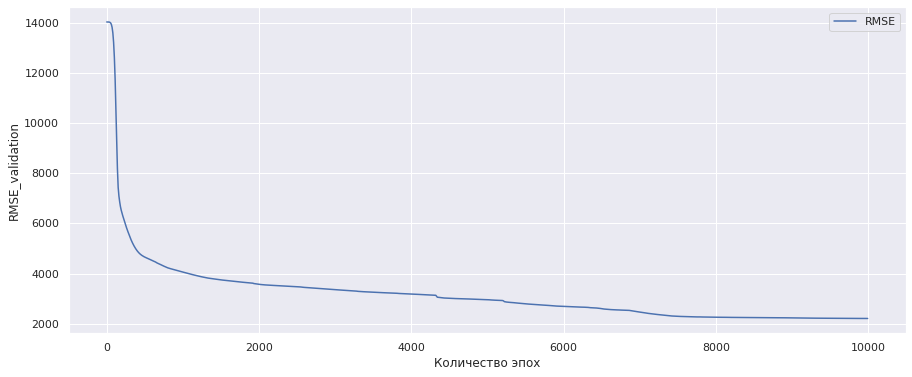

In [80]:
plt.figure(figsize=[15,6])
sns.lineplot(x=epochs, y=results, label='RMSE')
plt.legend()
plt.xlabel('Количество эпох')
plt.ylabel('RMSE_validation')
plt.show()

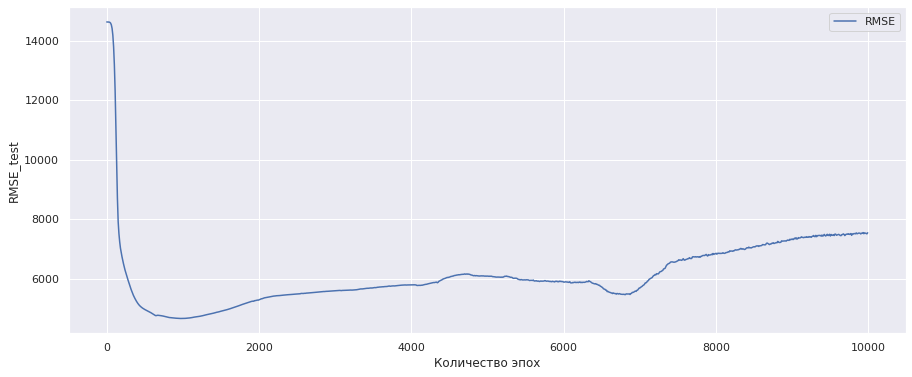

In [81]:
plt.figure(figsize=[15,6])
sns.lineplot(x=epochs, y=results_test, label='RMSE')
plt.legend()
plt.xlabel('Количество эпох')
plt.ylabel('RMSE_test')
plt.show()

Видно, что с увеличением числа эпох RMSE на тренировочной выборке асимптотически приближается к 2000. То есть, увеличивать количество эпох выше 8000 не имеет смысла. 

2. Теперь будем передавать данные нейронной сети - частями (батчами). Подберем оптимальный размер батча.

In [82]:
X_train.shape[0]

180

In [83]:
batch_list = [180, 90, 60, 40, 30, 20]

In [84]:
random.seed(1974)
np.random.seed(1974)
torch.manual_seed(1974)
torch.use_deterministic_algorithms(True)

In [85]:
res_test_b = {180: [], 290: [], 60: [], 40: [], 30: [], 20: []}

Размер батча 180 RMSE(2000 эпох)= 3712.172


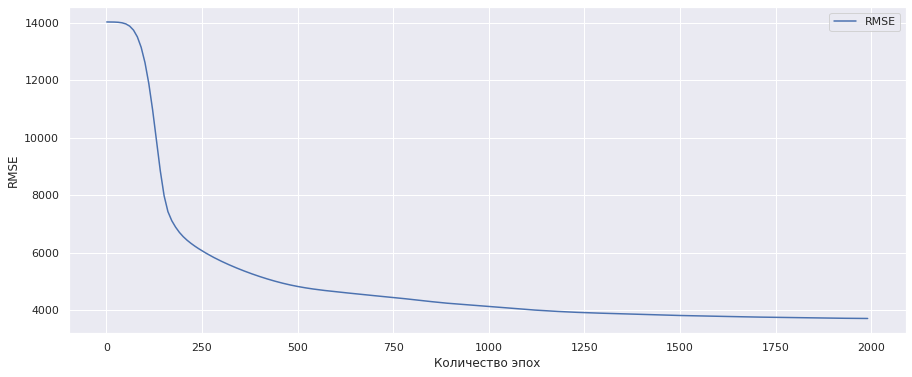

Размер батча 90 RMSE(2000 эпох)= 3570.351


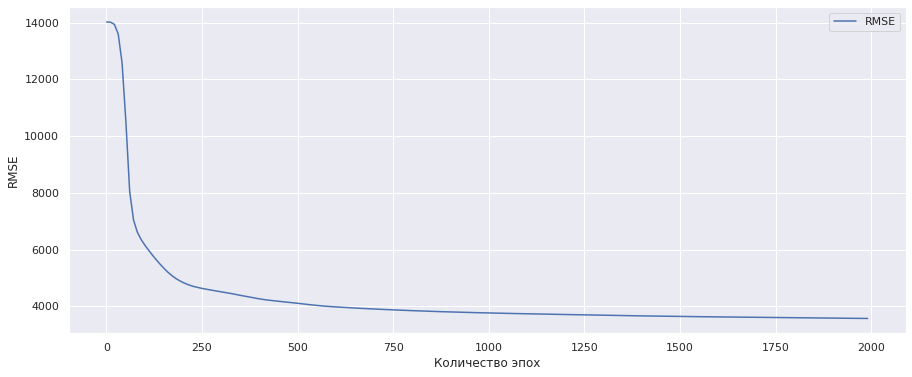

Размер батча 60 RMSE(2000 эпох)= 14027.552


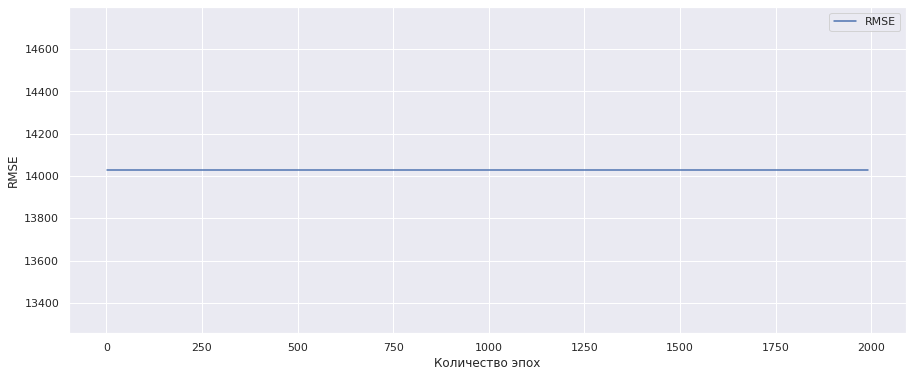

Размер батча 40 RMSE(2000 эпох)= 14027.552


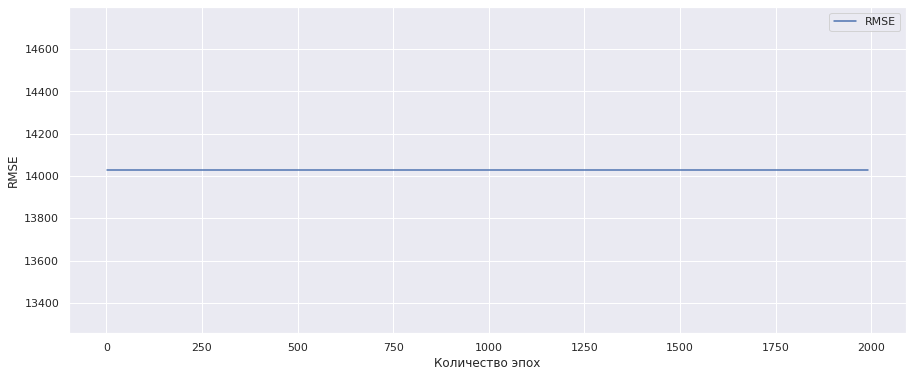

Размер батча 30 RMSE(2000 эпох)= 3137.4883


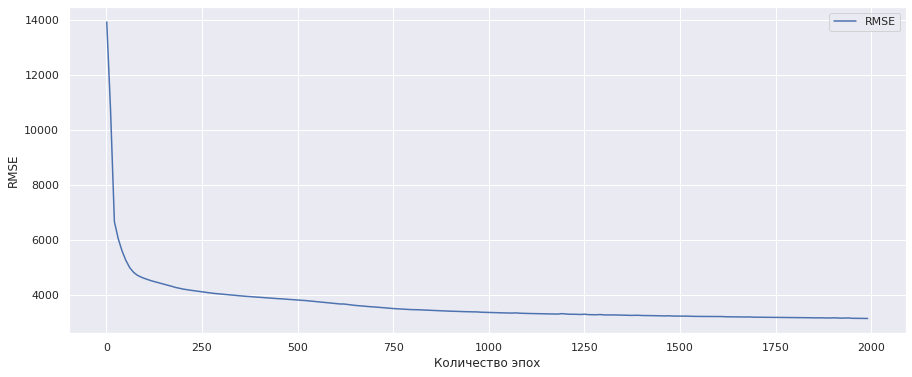

Размер батча 20 RMSE(2000 эпох)= 3924.6921


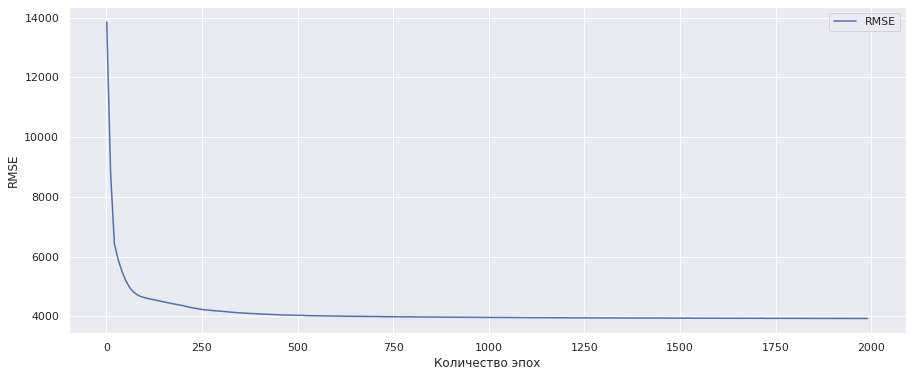

In [86]:
for batch_size in batch_list:
    
    results = np.array([])
    
    net = nn.Sequential(
        nn.Linear(16, 11),
        nn.ReLU(),
        nn.Linear(11, 7),
        nn.ReLU(),
        nn.Linear(7, 5), 
        nn.ReLU(),
        nn.Linear(5, 1), 
        nn.ReLU()
    )
    
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
    
    loss = nn.MSELoss()
    
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(1, 2001):
        order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size # посчитайте номер стартового объекта батча
            optimizer.zero_grad()
            
            batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            preds = net.forward(X_batch).flatten()
            
            loss_value = loss(preds, y_batch)
            
            loss_value.backward()
            
            optimizer.step()
            
        if epoch % 10 == 0:
            net.eval()
            test_preds = net.forward(X_test)
            res = mean_squared_error(y_train, net.forward(X_train).detach().numpy(), squared=False)
            results = np.append(results, res)
            
    print('Размер батча', batch_size, 'RMSE(2000 эпох)=', res)
    res_test_b.setdefault(batch_size, []).append(test_preds.detach().numpy())
    epochs = np.arange(1, 2001, 10)
    plt.figure(figsize=[15,6])
    sns.lineplot(x=epochs, y=results, label='RMSE')
    plt.legend()
    plt.xlabel('Количество эпох')
    plt.ylabel('RMSE')
    plt.show()

Оптимальный размер батча - 30. При этом RMSE, соответствующее 2000 эпохам, равно 3100 против 3700 в базовой модели. Однако без использования батчей, просто за счет увеличения количества эпох можно получить лучший результат, правда за большее время.

3. Попробуем применить Dropout и подобрать лучший параметр р - долю «выключенных» нейронов.

In [91]:
class Net_2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons, pr):
        super(Net_2, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, 11)
        self.dp1 = nn.Dropout(p=pr)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(11, 7)
        self.dp2 = nn.Dropout(p=pr)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(7, 5)
        self.dp3 = nn.Dropout(p=pr)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(5, 1)
        self.act4 = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.dp3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        return x

Создадим словарь, в который будут записаны предсказанные моделью на тестовой выборке температуры. Каждый элемент списка будет соответствовать своему значению параметра p Dropout. Параметр р будем менять от 0.1 до 0.9 с шагом 0.1.

In [92]:
res_test = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

Доля «выключенных» нейронов 0.1 RMSE(2000 эпох) 3924.287


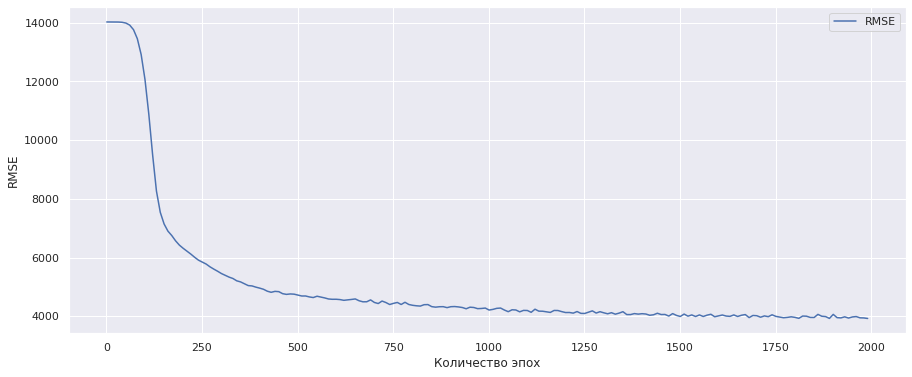

Доля «выключенных» нейронов 0.2 RMSE(2000 эпох) 14027.552


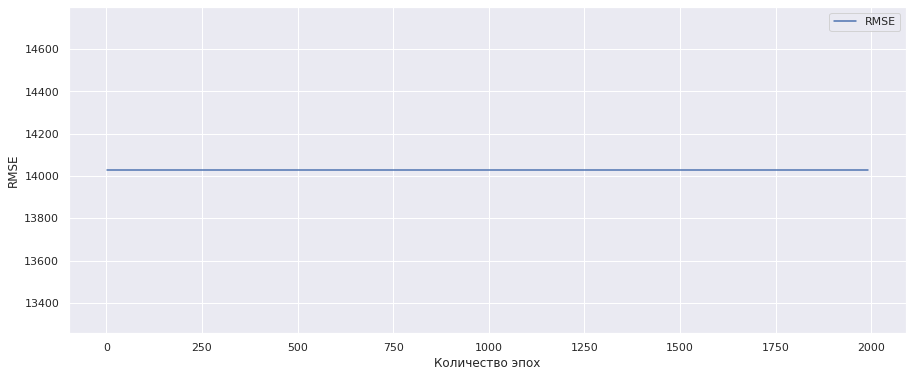

Доля «выключенных» нейронов 0.3 RMSE(2000 эпох) 4819.7266


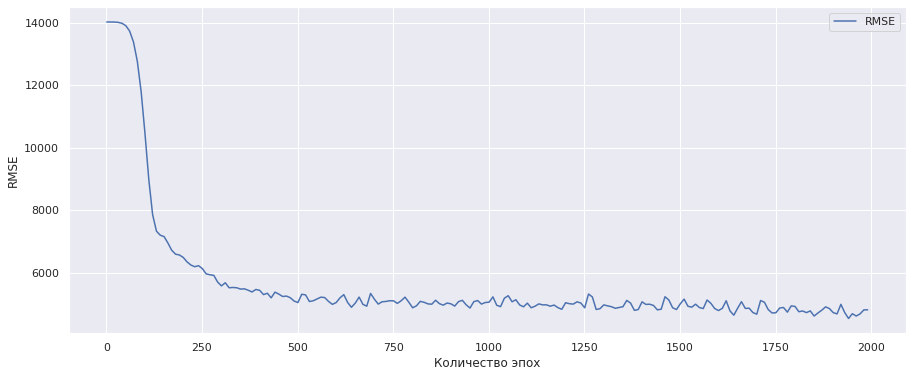

Доля «выключенных» нейронов 0.4 RMSE(2000 эпох) 5744.1743


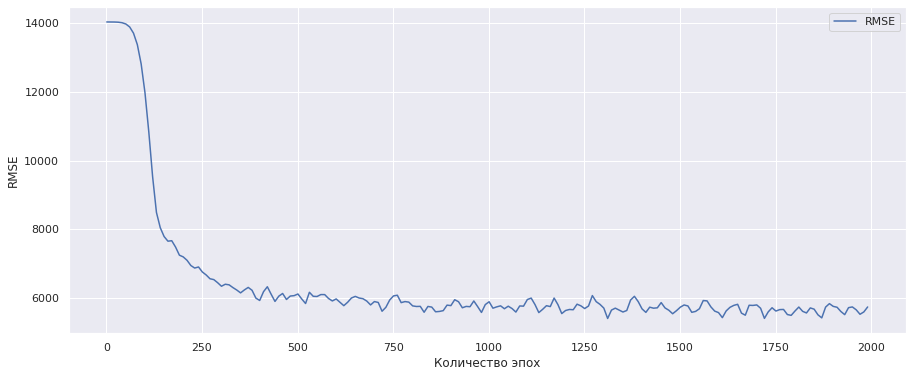

Доля «выключенных» нейронов 0.5 RMSE(2000 эпох) 6515.2104


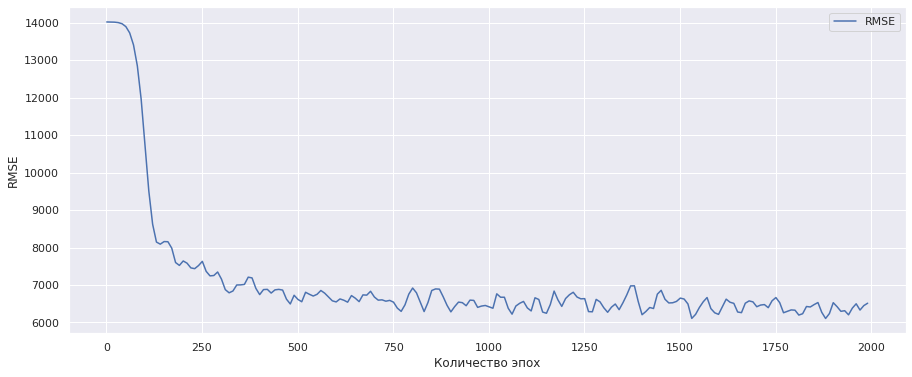

Доля «выключенных» нейронов 0.6 RMSE(2000 эпох) 7942.796


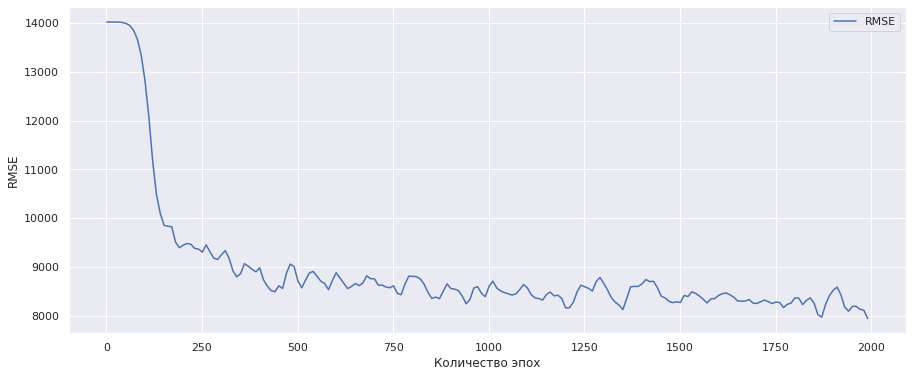

Доля «выключенных» нейронов 0.7 RMSE(2000 эпох) 10300.01


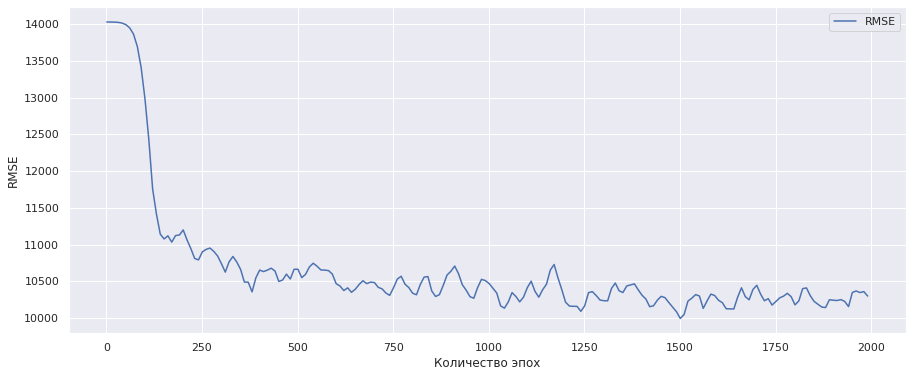

Доля «выключенных» нейронов 0.8 RMSE(2000 эпох) 10656.395


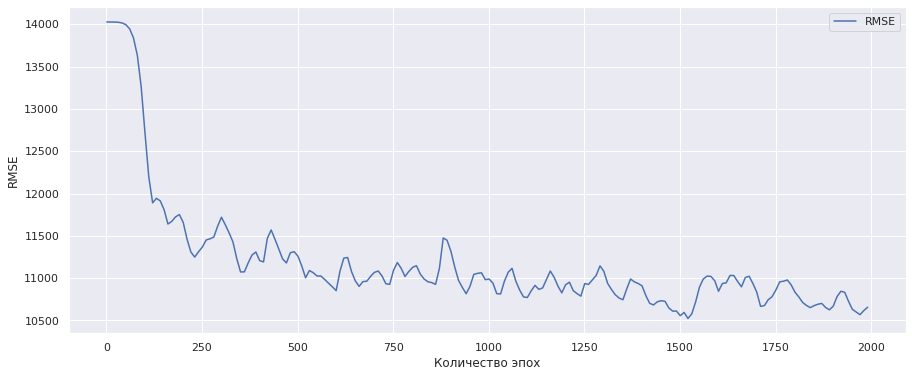

Доля «выключенных» нейронов 0.9 RMSE(2000 эпох) 12456.689


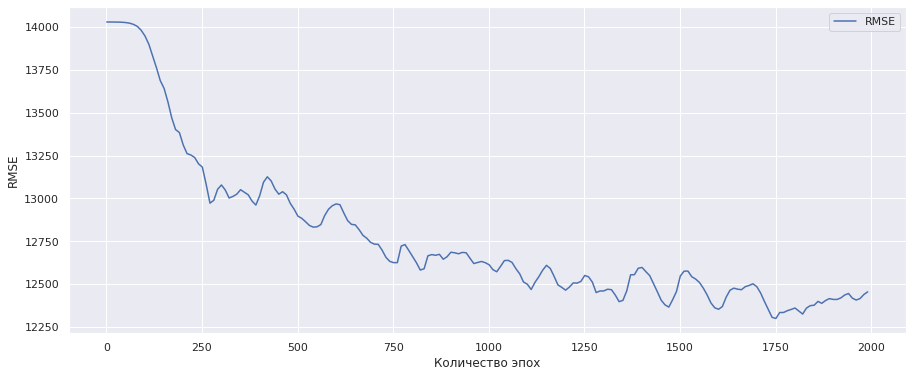

In [93]:
for i in range(1, 10, 1):
    
    pr = i/10
    net_2 = Net_2(16, 11, 7, 5, 1, pr)
    optimizer_2 = torch.optim.Adam(net_2.parameters(), lr=1e-2)
    loss_2 = nn.MSELoss()
    results_2 = np.array([])
    
    
    for epoch in range(1, 2001):
        
        optimizer_2.zero_grad()
          
        preds_2 = net_2.forward(X_train).flatten()
        
        loss_value_2 = loss_2(preds_2, y_train)
        
        loss_value_2.backward()
        
        optimizer_2.step()
        
        if epoch % 10 == 0:
            net_2.eval()
            test_preds_2 = net_2.forward(X_test)
        
            
            res_2 = mean_squared_error(y_train, net_2.forward(X_train).detach().numpy(), squared=False)
            
            results_2 = np.append(results_2, res_2)
            net_2.train()
            
    
        
    
    print('Доля «выключенных» нейронов', pr, 'RMSE(2000 эпох)', res_2)
    
    res_test.setdefault(i, []).append(test_preds_2.detach().numpy())
    
    epochs = np.arange(1, 2001, 10)
    plt.figure(figsize=[15,6])
    sns.lineplot(x=epochs, y=results_2, label='RMSE')
    plt.legend()
    plt.xlabel('Количество эпох')
    plt.ylabel('RMSE')
    plt.show()    

In [94]:
predict = np.array(res_test_b[30])

In [95]:
predict = torch.FloatTensor(predict).flatten()

In [96]:
predict

tensor([14817.9805,  3130.6094,  5124.2666, 14133.2324, 25560.9160,  6262.2627,
        28390.7422, 14323.3945,  3263.5146, 14756.2461,  2124.2268, 23181.5996,
         4289.1777, 16025.7979,  3819.2632, 13827.0078,  3163.8052,  3290.5420,
        14737.2598,  2856.8508,  3188.8616,  3616.5989, 34117.9922, 34840.7617,
        34790.3789, 27302.7578,  3699.7542, 18045.9434,  8453.0000, 19402.4316,
         3317.1436, 13567.4092, 11634.6221,  3091.9905,  3211.3586,  2879.5801,
         3224.3306,  3837.8638,  3133.8252,  3232.5122, 28001.3750,  4101.5088,
        14979.8213,  2993.5947, 24983.9316,  3003.6450, 25239.9805,  6025.9722,
         3072.2222,  3243.6699, 20669.9883,  3104.5449, 24568.7012,  3326.4832,
        17948.3848, 19170.6094,  4249.7905,  8588.0176,  3485.0229,  3574.4863])

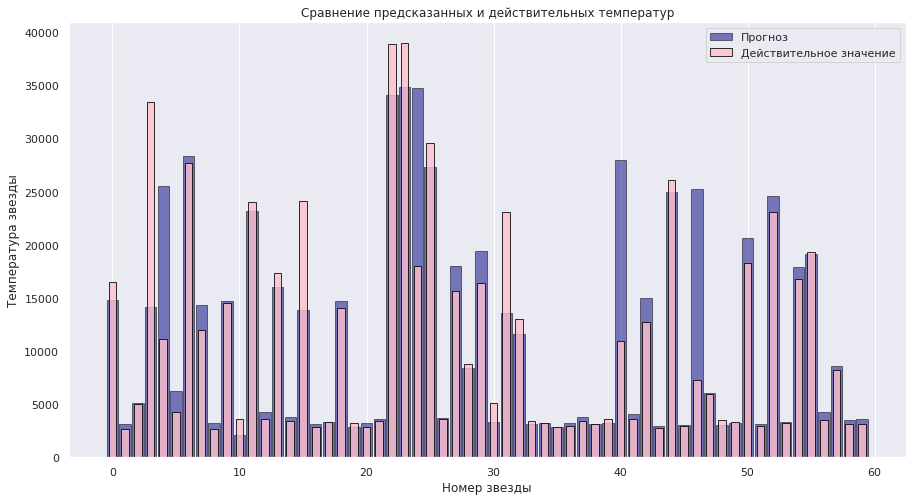

In [97]:
x = np.arange(60)
plt.figure(figsize = (15,8))
plt.bar(x, predict[:60], width = 0.9, color = 'navy', edgecolor = 'black', label='Прогноз', alpha=0.5)
plt.bar(x, y_test[:60], width = 0.6, color = 'pink', edgecolor = 'black', alpha=0.8, label='Действительное значение')
plt.title('Сравнение предсказанных и действительных температур')
plt.ylabel('Температура звезды')
plt.xlabel('Номер звезды')
plt.legend()
plt.grid(axis='y')
plt.show()

<a id='6'></a>
## Выводы

Для анализа предоставлен датафрейм из 240 строк с различными характеристиками звезд, на основании которых требуется предсказать температуру звезды, которая является целевым признаком в данной задаче.

Пропусков и дубликатов в данных не обнаружено.

Анализ данных показал, что в наименованиях цвета звезд присутствует некоторая путаница.

В интернете можно найти следующие данные по классификации цвета звезд:

The standard classes are (temperatures are in Kelvin):

O – Blue Stars: > 30,000 K

B – Blue-White Stars: 10,000 – 30,000 K

A – White Stars: 7,500 – 10,000 K

F – Yellow-White Stars: 6,000 – 7,500 K

G – Yellow Stars: 5,200-6,000 K

K – Orange Stars: 3,700 – 5,200 K

M – Red Stars: 2,400 – 3,700 K

В результате все названия цветов были приведены к данным семи типов цветов звезд.

В данных премущественно представлены сведения о не самых горячих звездах с температрами ниже 5000 К.

Основная часть звезд имеют температуру в диапазоне от 3300 до 15000 К. Распределение температуры сильно сдвинуто влево. Среднее значение температуры - 10500 К, медианное - 5800 К. Наблюдаются выбросы - значения выше 33000 К. Поскольку в действительности такие температуры звезд имеют место, то ничего из данных не выбрасываем.

В данных больше всего красных (не очень горячих) звезд, что соответствует распределению звезд по температуре.

Распределение относительной светимости несимметричное, сдвинуто влево. Присутствует большое число звезд с низкой светимостью.

В основном в данных присутствуют звезды, близкие по радиусу к Солнцу, однако есть и звезды - гиганты.

Распределение звезд по абсолютной звездной величине - бимодальное. В основном присутствуют либо очень яркие, либо тусклые звезды.

Анализ взаимосвязи целевого признака - температуры звезды с остальными параметрами показал следующее:

В целом, зависимости между относительной светимостью и температурой не видно, видно только, что у всех красных звезд примерно одинаковая температура, которая не зависит от относительной светимости.

Такая же картина для относительного радиуса. Для красных звезд температура просто определяется цветом звезды, то есть спектром. Общей зависимости нет.

Зависимость температуры от абсолютной звездной величины можно было бы определить для разных типов звезд. 3 тип звезд (звезды главной последовательности) хорошо ложатся на кривую типа exp(-x). На ее продолжение также хорошо попадают звезды 0 и 1 типа (коричневые и красные карлики). Зависимость для 2 типа звезд (белые карлики) можно было бы приблизительно считать линейной. То есть тут можно было бы обучать данные раздельно.
Из графика температура(светимость), как и из других, видно, что самые большие проблемы будут с предсказаниями звезд гигантов.

Из графика температура(тип звезды) видно, что для звезд 0 и 1 типа практически однозначно определяется температура. Они же преимущественно являются красными.
Из графика температура(цвет звезды) видно, что такие цвета звезды как красный, оранжевый и желтый практически однозначно определят температуру звезды.

Построение корреляционной матрицы подтверждает выводы, сделанные выше на основании графиков зависимости температуры от различных параметров звезды.

Самая высокая степень корреляции наблюдается между целевым признаком (температурой) и цветом звезды, а также абсолютной звездной величиной (0.7). Вместе с этим наблюдается очень высокая корреляция между двумя этими признаками - 0.92. При построении линейной модели, наверное, следовало бы оставить только один из этих признаков.


Перед обучением нейронной сети было проведено масштабирование числовых и кодирование категориальных признаков при помощи StandardScaler и OneHotEncoder.

В качестве базовой была задана  сеть с тремя скрытыми слоями. В качестве функции активации используем ReLU, так как она лучше работает с моделями регрессии. Перебор числа нейронов показал неплохие свойства для следующей архитектуры сети: Net(16, 11, 7, 5, 1).
Использовался оптимизатор Adam со скоростью обучения 1е-2.
В качестве метрики использовалась RMSE (квадратный корень из среднего значения квадрата всех ошибок), в качестве функции потерь, соответственно - MSE.
Число эпох было выбрано равным 2000.
В результате работы базовой модели получилось значение RMSE=3700 К, что ниже требуемого значения 4500.
Сравним значения, предсказанные моделью на тестовой выборке с действительными значениями.
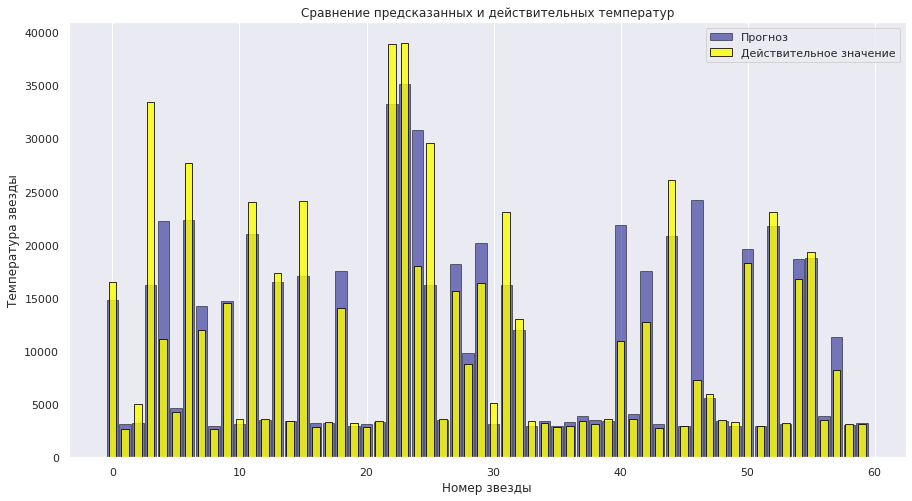 
Из сравнения видно, что лучше всего модель предсказывает температуры меньше 5000 К, то есть температуры красных звезд. Это неудивительно, так как именно для этих звезд цвет звезды практически однозначно определяет температуру.
Из графика видно, что есть особенно неудачные предсказания. Все звезды, проблемные для модели, имеют голубой цвет, абсолютную звездную величину в диапазоне (-8, -4) и преимущественно относятся к 4 классу (сверхгиганты).
Если бы я изучала звезды, то обратила бы на эту группу особое внимание, так как для них, возможно, температура определяется какими-то еще дополнительными факторами или процессами, протекающими внутри этих звезд.


Для улучшения модели были проанализированы параметры: число эпох, «dropout» и «размер батча».
Архитектура нейронной сети: количество слоёв, нейронов, вид функции активации — оставили как в базовой модели.

Показано, что с увеличением числа эпох, метрика RMSE асимптотически приближается к 2000. То есть, увеличивать количество эпох выше 8000 не имеет смысла.

Оптимальный размер батча - 30. При этом RMSE, соответствующее 2000 эпохам, равно 3100 против 3700 в базовой модели. Без использования батчей, просто за счет увеличения количества эпох можно получить лучший результат для метрики на тренировочной выборке, правда за большее время. Тем не менее, зависимость метрики RMSE от числа эпох для тестовой выборки показывает ухудшение метрики после 1000 эпох (переобучение).


Использование Dropout привело к ухудшению модели.
Сравним значения, предсказанные моделью с числом батчей, равным 30, на тестовой выборке с действительными значениями температуры.
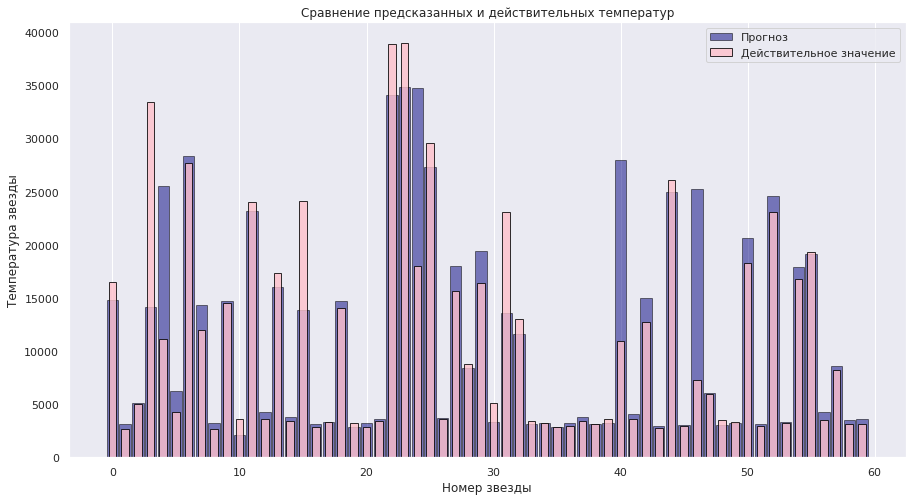 
Особого улучшения по сравнению с использованием базовой модели не наблюдается.
